In [854]:
import os
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from numpy import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# XGBoost

## Load data

In [855]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/clean/aligned_data', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

192

## Sort by date

In [856]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove columns

In [857]:
df = df.drop(columns=['soil region', 'landuse code'])
df = df.dropna()
len(df)

132

## Add year and month as features

In [858]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Log transform

In [859]:
df["nitrate"] = np.log1p(df["nitrate"])

## Change column type

In [860]:
for col in ['soil region', 'landuse code', 'soilunit_code_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [861]:
df.dtypes

bro-id                                 object
nitrate                               float64
geometry                               object
date                      datetime64[ns, UTC]
population                            float64
groundwater depth                     float64
elevation                             float64
lon                                   float64
lat                                   float64
precipitation                         float64
temperature                           float64
n deposition                          float64
soilunit_code_1                      category
organicmattercontent_1                float64
density_1                             float64
acidity_1                             float64
month                                   int32
year                                    int32
dtype: object

## Remove nitrate outliers

In [862]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
outliers

Outliers found: 0


,bro-id,nitrate,geometry,date,population,groundwater depth,elevation,lon,lat,precipitation,temperature,n deposition,soilunit_code_1,organicmattercontent_1,density_1,acidity_1,month,year


<Axes: >

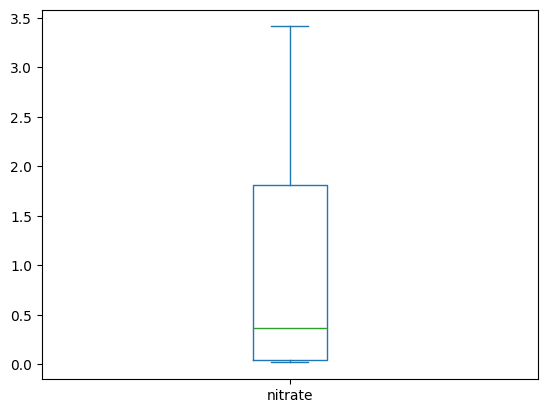

In [863]:
df[["nitrate"]].plot(kind = "box")

In [864]:
# top_nitrate_outliers = list(df["Nitrate"].sort_values()[-len(outliers):].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

## Test / train split

In [865]:
train_df = df[df["year"].isin([2012, 2013, 2014, 2015, 2016, 2017])]
test_df  = df[df["year"].isin([2018, 2019, 2020])]

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"])
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"])
y_test = test_df["nitrate"]

Train: 84
Test: 48


## Preprocess data

In [866]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [867]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['soilunit_code_1']
Numerical: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1']
All X_train columns: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'soilunit_code_1', 'organicmattercontent_1', 'density_1', 'acidity_1']


In [868]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [869]:
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=4
)

In [870]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("xgb", xgb_reg)
])

In [871]:
param_dist = {
    "xgb__n_estimators": [30, 50, 100],
    "xgb__max_depth": [5, 7, 8],
    "xgb__learning_rate": [0.05, 0.1, 0.15],
    "xgb__subsample": [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.3, 0.4, 0.6]
}

## Hyperparameter tuning

In [872]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=60,
    cv=tscv,
    scoring="r2",
    verbose=1,
    random_state=9,
    n_jobs=-1
)
search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('cat_ohe',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['soilunit_code_1']),
                                                                              ('num_scaler',
                                                                               StandardScaler(),
                                                                               ['population',
                                                                                'groundwater '
                                                                                'depth',
                                                                                'elevation',
                                                                                'precipitation',
                                                                                'tempera...
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None,
                                                           random_state=4, ...))]),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.3, 0.4,
                                                                  0.6],
                                        'xgb__learning_rate': [0.05, 0.1, 0.15],
                                        'xgb__max_depth': [5, 7, 8],
                                        'xgb__n_estimators': [30, 50, 100],
                                        'xgb__subsample': [0.6, 0.8, 1.0]},
                   random_state=9, scoring='r2', verbose=1)

## Train score

In [873]:
pred_train = search.predict(X_train)
print("Train R2:", r2_score(np.expm1(y_train), np.expm1(pred_train)))
print("Train MAE:", mean_absolute_error(np.expm1(y_train), np.expm1(pred_train)))
print("Test RMSE:", sqrt(mean_squared_error(np.expm1(y_train), np.expm1(pred_train))))

Train R2: 0.9999957898071512
Train MAE: 0.004856586913622447
Test RMSE: 0.010655578996286167


## Test score

In [874]:
pred_nitrate = search.predict(X_test)
print("Best CV R2:", search.best_score_)
print("Best params:", search.best_params_)
print("\n")

print("Test R2:", r2_score(np.expm1(y_test), np.expm1(pred_nitrate)))
print("Test MAE:",mean_absolute_error(np.expm1(y_test), np.expm1(pred_nitrate)))
print("Test RMSE:", sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred_nitrate))))

Best CV R2: 0.6031328586759106
Best params: {'xgb__subsample': 1.0, 'xgb__n_estimators': 100, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.15, 'xgb__colsample_bytree': 0.3}


Test R2: 0.8017097572795215
Test MAE: 1.0490255752640467
Test RMSE: 1.7644294681329094


## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

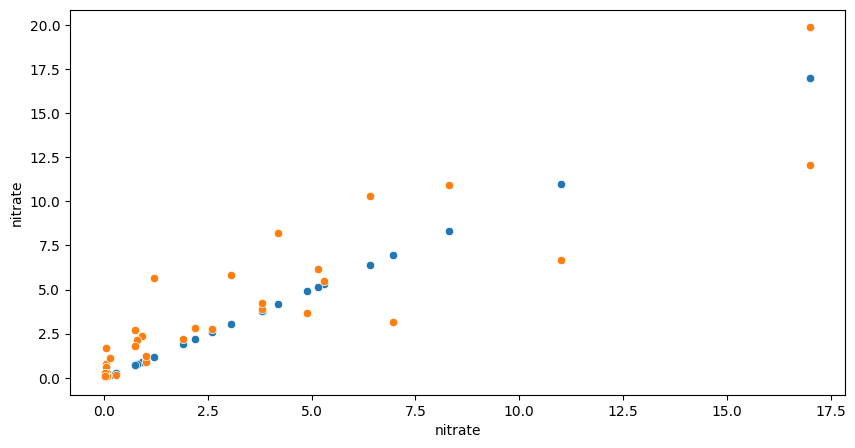

In [875]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = np.expm1(y_test), y = np.expm1(y_test), ax = ax)
sns.scatterplot(x = np.expm1(y_test), y = np.expm1(pred_nitrate), ax = ax)

In [876]:
# fix, ax = plt.subplots(figsize= (10,5))

# sns.scatterplot(x = y_test, y = y_test, ax = ax)
# sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

Text(0, 0.5, 'Residuals')

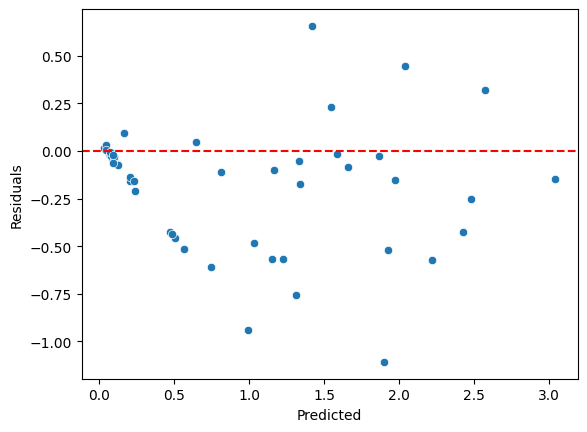

In [877]:
preds = search.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Interpretability

In [878]:
best_pipe = search.best_estimator_
xgb_model = best_pipe.named_steps["xgb"]
feature_names = best_pipe.named_steps["prep"].get_feature_names_out()

### Default interpretability: Gain

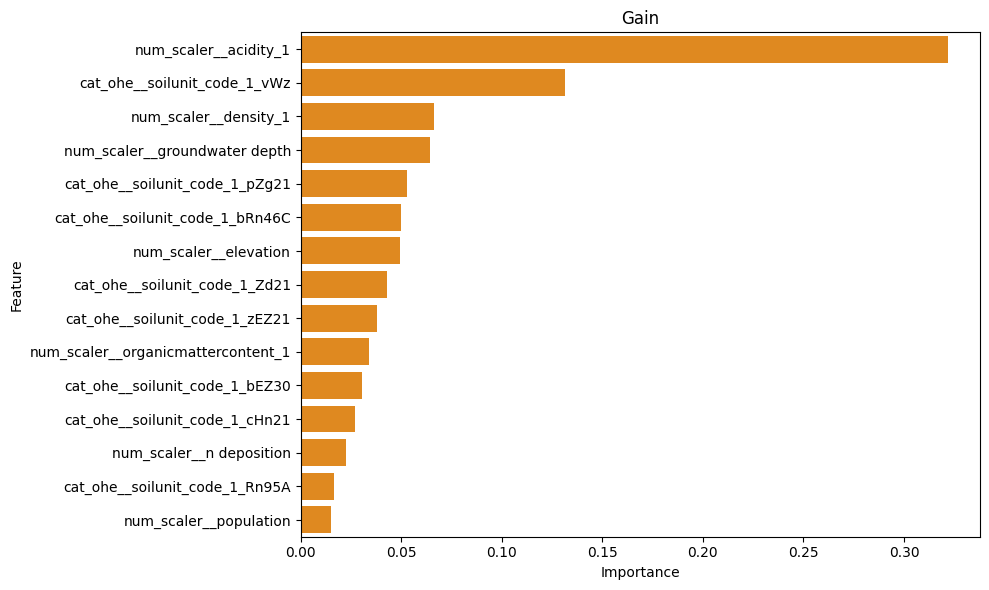

In [879]:
feature_names = best_pipe.named_steps["prep"].get_feature_names_out()

importances = xgb_model.feature_importances_

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), color="darkorange")
plt.title("Gain")
plt.tight_layout()
plt.show()

In [880]:
booster = xgb_model.get_booster()

feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

importance_types = ["gain", "cover", "weight"]
# importance_types = ["gain"]
importance_data = []

for imp_type in importance_types:
    imp_dict = booster.get_score(importance_type=imp_type)
    for fx, val in imp_dict.items():
        importance_data.append({
            "Feature": feature_map.get(fx, fx), #here we map f1, f2, etc with real feature names
            "Importance": val,
            "Type": imp_type
        })

In [881]:
# convert list of dictionaries to pandas df
importances_df = pd.DataFrame(importance_data)

# normalize the feature importances within each importance type
# divide every value in that group by the total sum of the group
# so it always ranges between (0 - 1)
importances_df["Importance"] = importances_df.groupby("Type")["Importance"].transform(lambda x: x / x.sum())

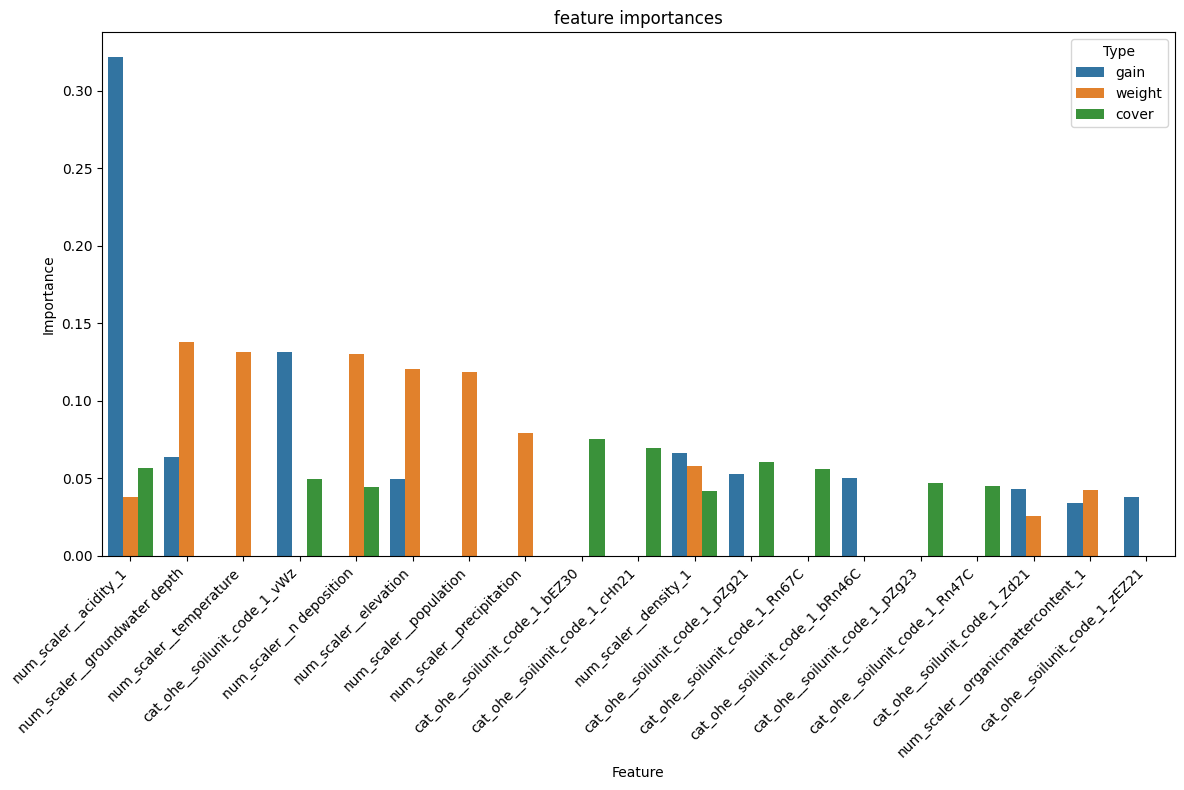

In [882]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("feature importances")
plt.tight_layout()
plt.show()


# Model-agnostic interpretability

In [883]:
feature_names = best_pipe.named_steps["prep"].get_feature_names_out()
X_test_transformed = best_pipe.named_steps["prep"].transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

## Permutation

In [884]:
result = permutation_importance(
    estimator=best_pipe.named_steps["xgb"],  # just the model
    X=X_test_transformed,
    y=y_test,
    n_repeats=30,
    random_state=42,
    scoring="r2",
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean,
    "Type": "permutation"
})

perm_df["Importance"] /= perm_df["Importance"].sum()

combined_df = pd.concat([importances_df, perm_df], axis=0)

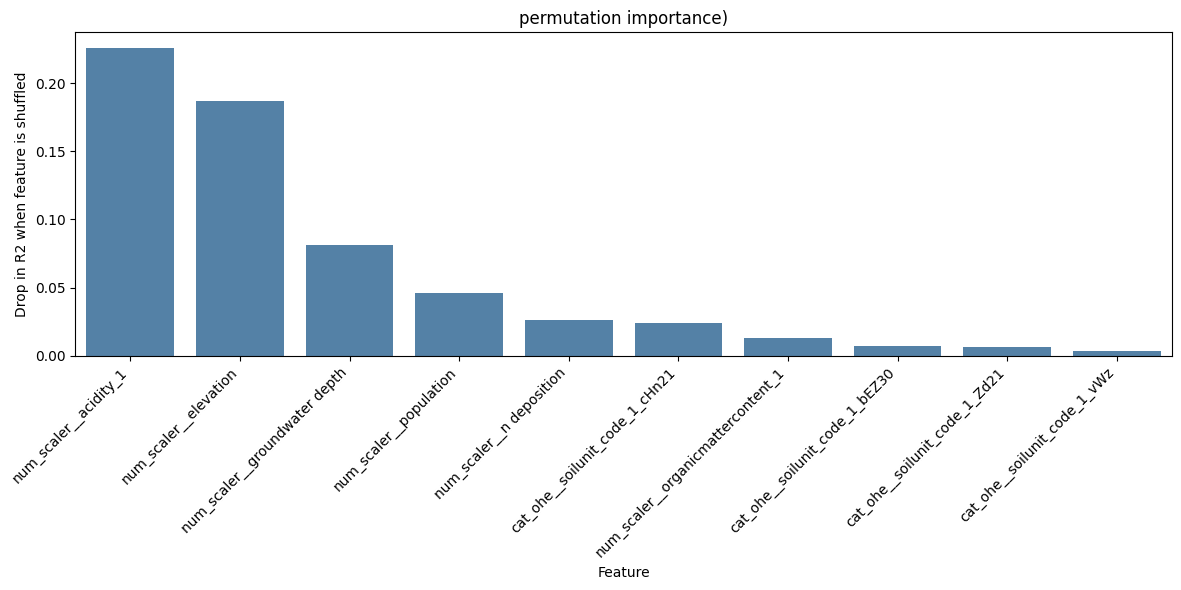

In [885]:
perm_df_raw = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean,
    "Std": result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=perm_df_raw.head(10),
    x="Feature",
    y="Importance",
    color="steelblue"
)
plt.xticks(rotation=45, ha="right")
plt.title("permutation importance)")
plt.ylabel("Drop in R2 when feature is shuffled")
plt.tight_layout()
plt.show()

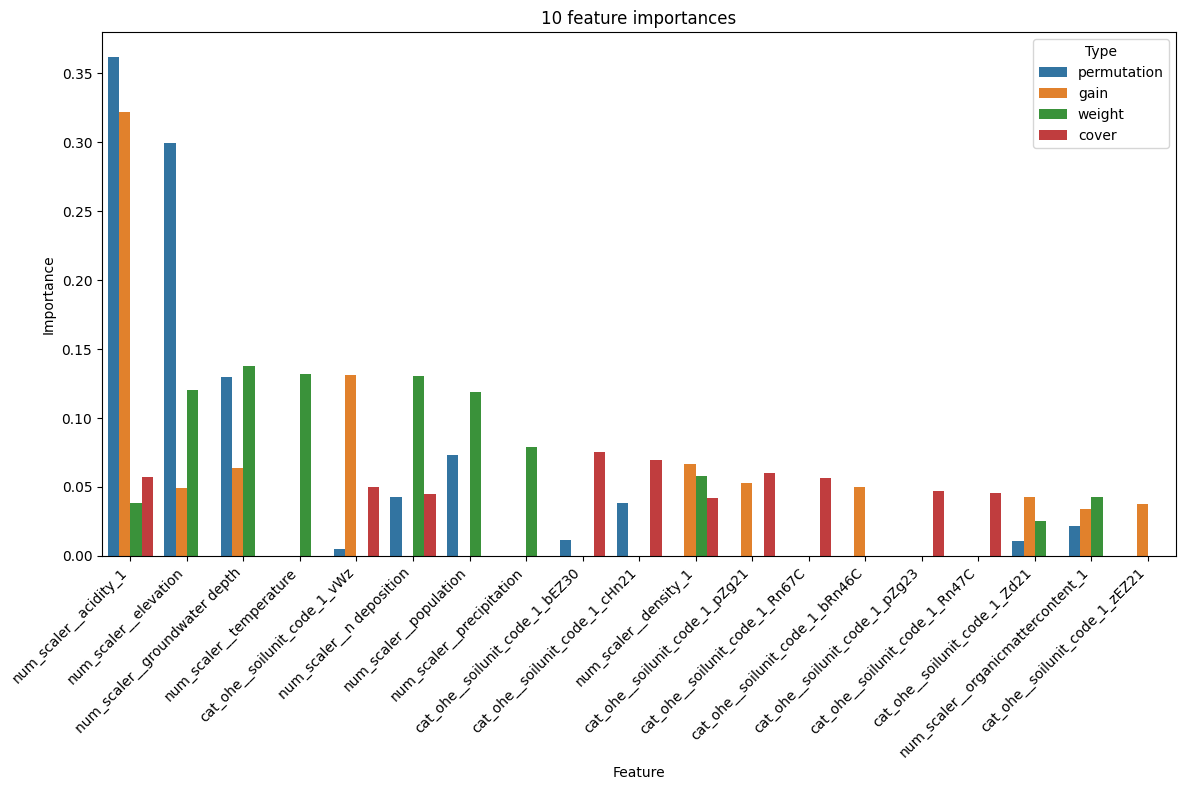

In [886]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("10 feature importances")
plt.tight_layout()
plt.show()

## Tree SHAP

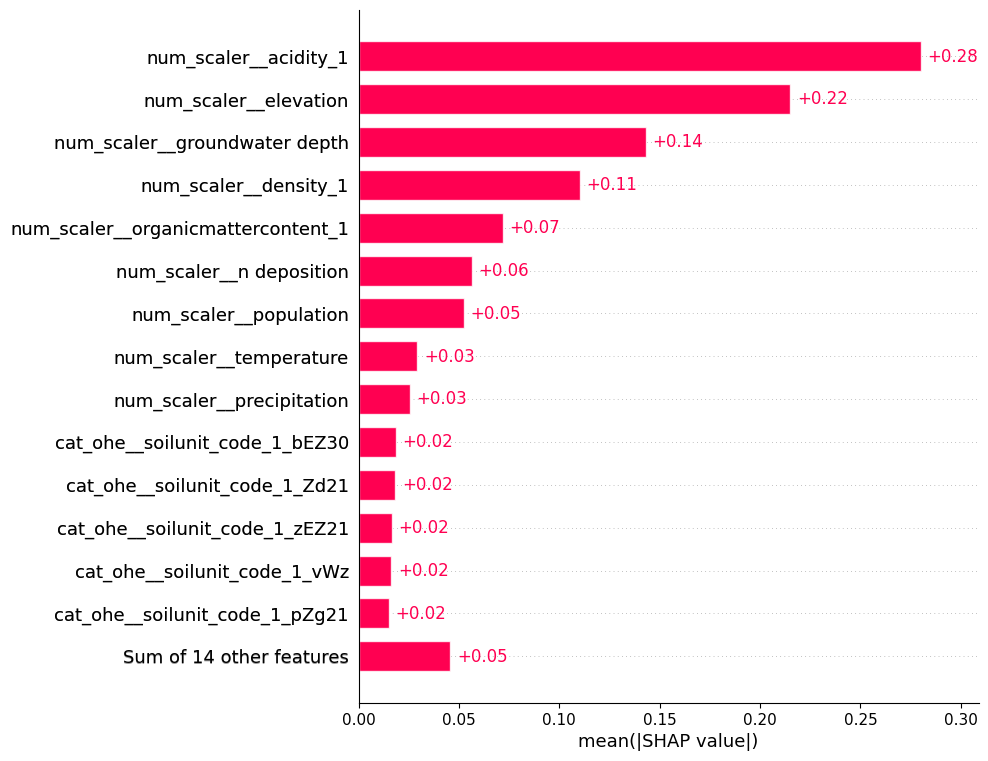

In [887]:
explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test_transformed_df)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_transformed_df.values,
    feature_names=X_test_transformed_df.columns
)

shap.plots.bar(shap_explanation, max_display=15)

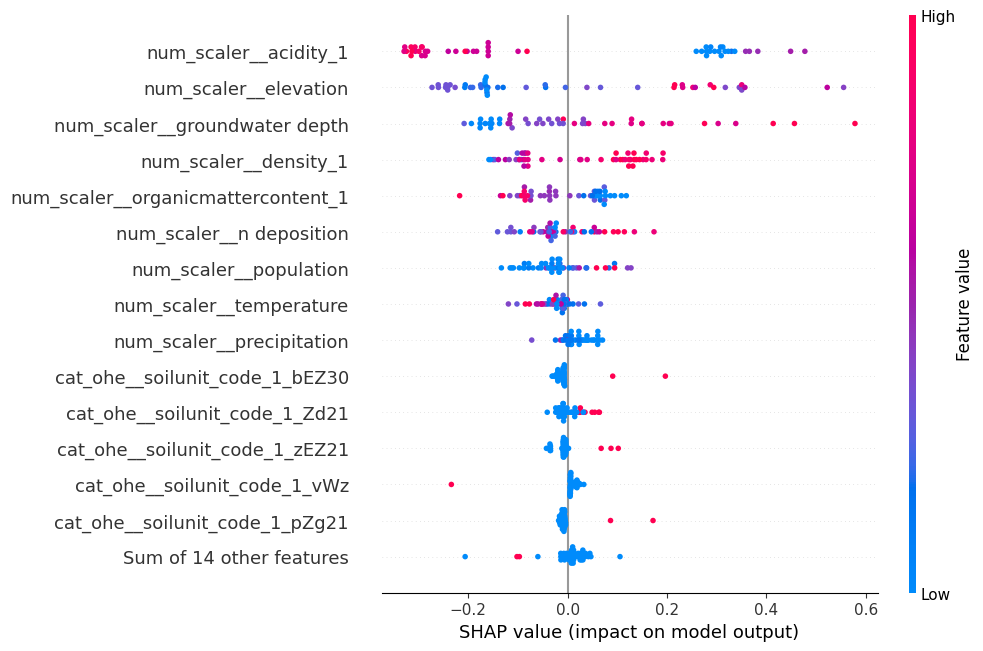

In [888]:
shap.plots.beeswarm(shap_explanation, max_display=15)